In [14]:
import pandas as pd
import numpy as np
import cupy as cp

import time
import requests
import datetime 
import logging
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append('C:/Users/dohyu/Desktop/Github/side_proj_fifa')

import matplotlib.pyplot as plt 
import matplotlib as mpl

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns 
import scipy.stats as stats

import xgboost as xgb
import sqlalchemy

from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
def db_conn(_username, _password, _host, _port, _database) : 
    db_engine = sqlalchemy.engine.URL.create(
        drivername = "mysql+pymysql",
        username = _username,
        password = _password,
        host = _host,
        port = _port,
        database = _database,
    )

    return create_engine(db_engine)

In [16]:
engine = db_conn('root', 'Dhyoon96!', '127.0.0.1', 3306, 'side_proj_fco')
df_query = 'SELECT * FROM match_user'

with engine.connect() as connection:
    df1 = pd.read_sql(df_query, con = connection)

df1 = df1[df1['match_endtype'] == 0].reset_index(drop = True) # 정상 종료된 데이터만 사용

# For rate columns (Variables that have 'try' and 'suc' columns)
df1['match_total_pass_rate'] = (df1['match_total_pass_suc'] / df1['match_total_pass_try']).replace(np.nan, 0)

df1['match_total_pass_short_rate'] = (df1['match_total_pass_short_suc'] / df1['match_total_pass_short_try']).replace(np.nan, 0)
df1['match_total_pass_long_rate'] = (df1['match_total_pass_long_suc'] / df1['match_total_pass_long_try']).replace(np.nan, 0)
df1['match_total_pass_through_rate'] = (df1['match_total_pass_through_suc'] / df1['match_total_pass_through_try']).replace(np.nan, 0)

df1['match_total_shoot_inpenalty_rate'] = (df1['match_total_shoot_inpenalty_suc'] / df1['match_total_shoot_inpenalty_try']).replace(np.nan, 0)
df1['match_total_shoot_outpenalty_rate'] = (df1['match_total_shoot_outpenalty_suc'] / df1['match_total_shoot_outpenalty_try']).replace(np.nan, 0)

# For fail columns (Variables that have 'try' and 'suc' columns)
df1['match_total_pass_fail'] = df1['match_total_pass_try'] - df1['match_total_pass_suc']

df1['match_total_pass_short_fail'] = df1['match_total_pass_short_try'] - df1['match_total_pass_short_suc']
df1['match_total_pass_long_fail'] = df1['match_total_pass_long_try'] - df1['match_total_pass_long_suc']
df1['match_total_pass_through_fail'] = df1['match_total_pass_through_try'] - df1['match_total_pass_through_suc']

df1['match_total_shoot_inpenalty_fail'] = df1['match_total_shoot_inpenalty_try'] - df1['match_total_shoot_inpenalty_suc']
df1['match_total_shoot_outpenalty_fail'] = df1['match_total_shoot_outpenalty_try'] - df1['match_total_shoot_outpenalty_suc']

In [17]:
df1.describe()

,match_endtype,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,match_total_shoot,match_total_shoot_eff,match_total_goal,attack_position_ratings,...,match_total_pass_long_rate,match_total_pass_through_rate,match_total_shoot_inpenalty_rate,match_total_shoot_outpenalty_rate,match_total_pass_fail,match_total_pass_short_fail,match_total_pass_long_fail,match_total_pass_through_fail,match_total_shoot_inpenalty_fail,match_total_shoot_outpenalty_fail
count,1342.0,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,...,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.00000
mean,0.0,50.023845,4.186649,71.612519,100.733234,88.654247,7.750373,5.616244,2.392697,6.924173,...,0.457057,0.828329,0.386505,0.148569,12.078987,4.246647,2.671386,3.681818,3.257079,2.07079
std,0.0,5.295253,0.423157,14.684464,20.770334,20.291639,3.352670,2.701584,1.540419,0.714320,...,0.281647,0.123126,0.266170,0.253765,3.897228,2.383350,1.923612,2.529636,2.183647,1.82539
min,0.0,30.000000,2.927780,35.000000,46.000000,34.000000,1.000000,0.000000,0.000000,4.540000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.0,47.000000,3.922220,62.000000,86.000000,74.000000,5.000000,4.000000,1.000000,6.462500,...,0.285714,0.782609,0.200000,0.000000,9.000000,3.000000,1.000000,2.000000,2.000000,1.00000
50%,0.0,50.000000,4.161110,71.000000,100.000000,87.000000,7.000000,5.000000,2.000000,6.900000,...,0.500000,0.840000,0.348485,0.000000,12.000000,4.000000,2.000000,3.000000,3.000000,2.00000
75%,0.0,53.000000,4.388890,81.000000,114.000000,102.000000,10.000000,7.000000,3.000000,7.380000,...,0.666667,0.900000,0.500000,0.250000,15.000000,6.000000,4.000000,5.000000,5.000000,3.00000
max,0.0,75.000000,6.394440,136.000000,176.000000,156.000000,23.000000,16.000000,9.000000,9.430000,...,1.000000,1.000000,1.000000,1.000000,28.000000,14.000000,12.000000,18.000000,16.000000,10.00000


In [34]:
# Get columns from match_user_visualization VIF Check
df_col_temp = ['match_result'] + ['match_total_pass_long_try',
                                  'match_total_shoot_outpenalty_try',
                                  'match_total_shoot_inpenalty_try',
                                  'match_total_pass_long_rate',
                                  'match_total_shoot_inpenalty_rate',
                                  'match_total_shoot_outpenalty_rate']


In [36]:
df2 = df1[((df1['match_result'] == '승') | (df1['match_result'] == '패'))]
# df2 = df2.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 'match_endtype'])

df2 = df2[df_col_temp]

df2['match_result'] = df2['match_result'].map({'승': 1, '패': 0})

X = df2.drop('match_result', axis = 1)
y = df2['match_result']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = y)

scaler = MinMaxScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
X_test_scaled = scaler.transform(X_test)

X_temp_scaled_gpu = cp.array(X_temp_scaled)
X_test_scaled_gpu = cp.array(X_test_scaled)
y_temp_gpu = cp.array(y_temp)
y_test_gpu = cp.array(y_test)

# RandomForest Classifier

In [37]:
model_rfc = RandomForestClassifier(random_state = 42)

kf_rfc = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

param_grid_rfc = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rfc = GridSearchCV(estimator = model_rfc, 
                           param_grid = param_grid_rfc, 
                           cv = kf_rfc, 
                           n_jobs = -1, 
                           verbose = 2)

In [38]:
grid_search_rfc.fit(X_temp_scaled, y_temp)

best_model_rfc = grid_search_rfc.best_estimator_

y_test_pred_rfc = best_model_rfc.predict(X_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_rfc))
print("\nClassification Report on Test Set_RFC:\n", classification_report(y_test, y_test_pred_rfc))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Test Accuracy: 0.7746478873239436

Classification Report on Test Set_RFC:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       106
           1       0.76      0.80      0.78       107

    accuracy                           0.77       213
   macro avg       0.78      0.77      0.77       213
weighted avg       0.78      0.77      0.77       213



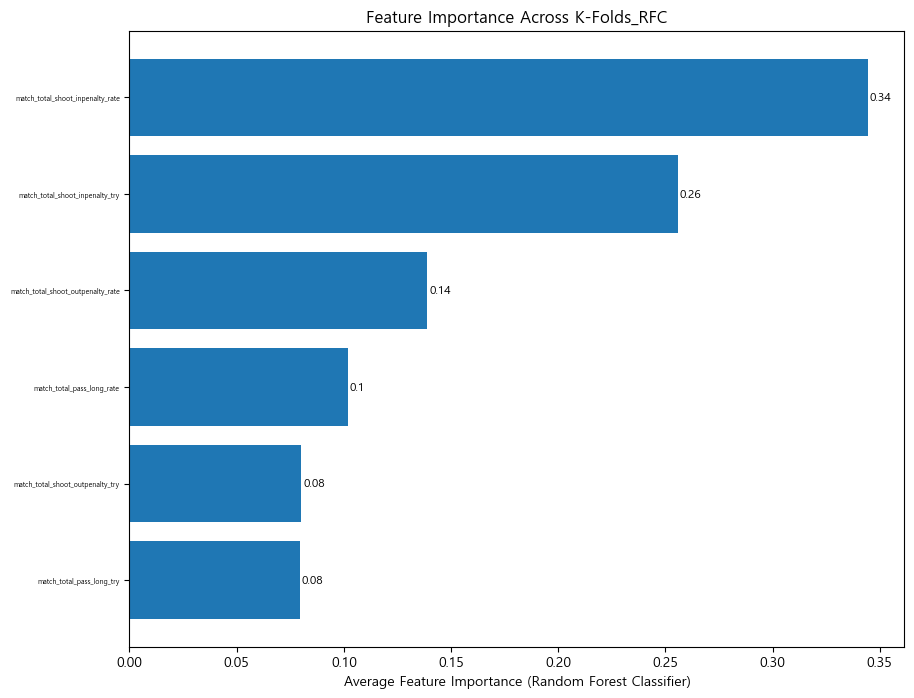

In [39]:
feature_importance_avg_rfc = best_model_rfc.feature_importances_
sorted_idx_rfc = feature_importance_avg_rfc.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx_rfc], feature_importance_avg_rfc[sorted_idx_rfc])
plt.xlabel("Average Feature Importance (Random Forest Classifier)")
plt.title("Feature Importance Across K-Folds_RFC")

plt.tick_params(axis = 'y', labelsize = 5)  
plt.tick_params(axis = 'x') 

for i, v in enumerate(feature_importance_avg_rfc[sorted_idx_rfc]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

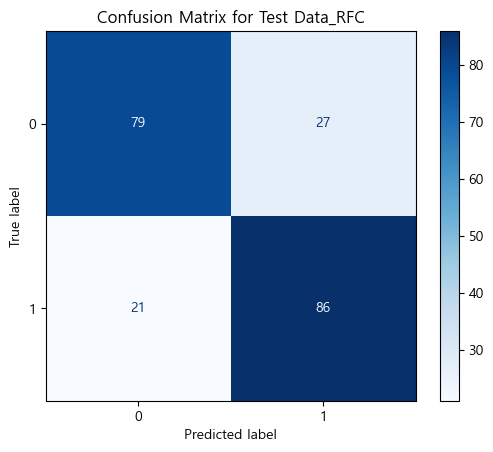

In [47]:
test_result_rfc = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred_rfc
})

cm_rfc = confusion_matrix(y_test, y_test_pred_rfc)

disp_rfc = ConfusionMatrixDisplay(confusion_matrix = cm_rfc, display_labels = best_model_rfc.classes_)
disp_rfc.plot(cmap = 'Blues', values_format = 'd')
plt.title("Confusion Matrix for Test Data_RFC")
plt.show()

# 패 : 0, 승 : 1

# XGBoost Classifier with K-fold, GridSearch

In [12]:
model_xgb = xgb.XGBClassifier(
    tree_method = 'gpu_hist',  
    eval_metric = "logloss",
    use_label_encoder = False,  
    random_state = 42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]}

kf_xgb = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_search_xgb = GridSearchCV(estimator = model_xgb, 
                               param_grid = param_grid_xgb, 
                               cv = kf_xgb, 
                               verbose = 1, 
                               n_jobs = -1)

In [13]:
grid_search_xgb.fit(X_temp_scaled_gpu.get(), y_temp_gpu.get())

print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best cross-validation score: ", grid_search_xgb.best_score_)

best_model_xgb = grid_search_xgb.best_estimator_

y_test_pred_xgb = best_model_xgb.predict(X_test_scaled_gpu.get())

print("\nTest Accuracy:", accuracy_score(y_test_gpu.get(), y_test_pred_xgb))
print("\nClassification Report on Test Set:\n", classification_report(y_test_gpu.get(), y_test_pred_xgb))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score:  0.7761904761904763

Test Accuracy: 0.7784810126582279

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77        78
           1       0.78      0.79      0.78        80

    accuracy                           0.78       158
   macro avg       0.78      0.78      0.78       158
weighted avg       0.78      0.78      0.78       158



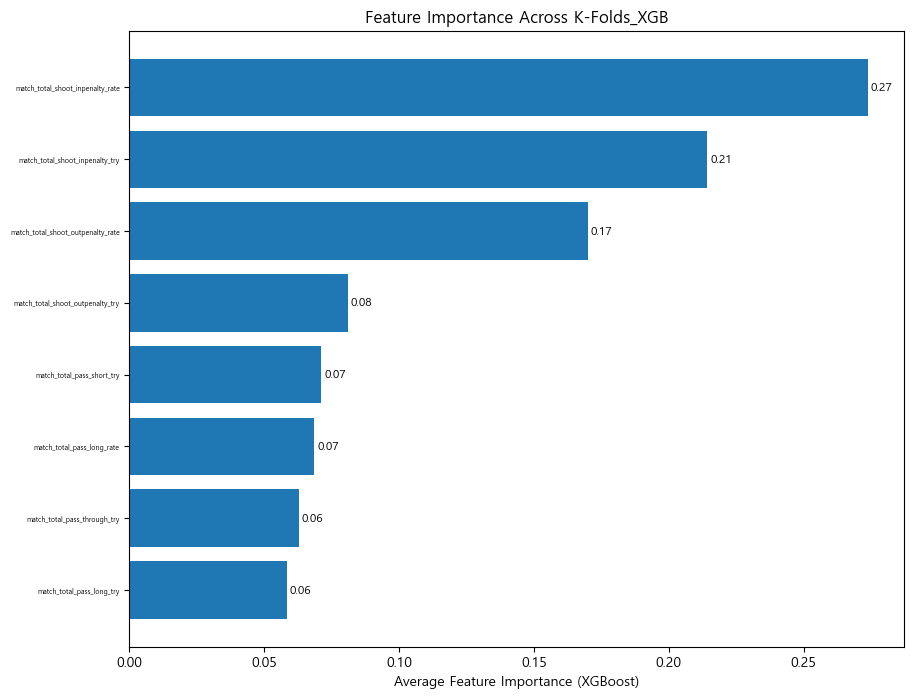

In [16]:
feature_importance_avg_xgb = best_model_xgb.feature_importances_
sorted_idx_xgb = feature_importance_avg_xgb.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx_xgb], feature_importance_avg_xgb[sorted_idx_xgb])
plt.xlabel("Average Feature Importance (XGBoost)")
plt.title("Feature Importance Across K-Folds_XGB")

plt.tick_params(axis = 'y', labelsize = 5)  
plt.tick_params(axis = 'x')  

for i, v in enumerate(feature_importance_avg_xgb[sorted_idx_xgb]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

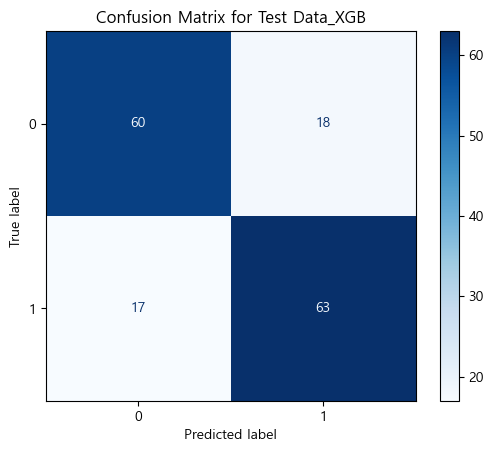

In [17]:
test_result_xgb = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred_xgb
})

cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

disp_rc = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = best_model_xgb.classes_)
disp_rc.plot(cmap = 'Blues', values_format = 'd')
plt.title("Confusion Matrix for Test Data_XGB")
plt.show()